Clean the data & start some EDA

In [1]:
import nltk
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Load in the data into a dataframe and change data types 

data = pd.read_csv('climber_logs.csv')
data['comment_date'] = pd.to_datetime(data['comment_date'])
data['climb_date'] = pd.to_datetime(data['climb_date'])
data['comment'] = data['comment'].replace(np.nan, '', regex=True)

print(data.info())
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35638 entries, 0 to 35637
Data columns (total 4 columns):
mountain        35638 non-null object
comment         35638 non-null object
comment_date    35638 non-null datetime64[ns]
climb_date      22860 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 1.1+ MB
None


,mountain,comment,comment_date,climb_date
0,Mount Whitney,Did this in a single day... very difficult for...,2018-11-19 08:51:00,2015-09-05
1,Mount Whitney,Mountaineers Route - first 14er,2018-11-01 06:34:00,NaT
2,Mount Whitney,Standard route from Whitney Portal via Trail C...,2018-10-01 12:44:00,2018-10-27
3,Mount Whitney,Worth hiking the 220-something miles along the...,2018-09-10 10:23:00,2016-07-23
4,Mount Whitney,"My brother John, his son and I backpacked in t...",2018-08-15 02:28:00,2018-08-10
5,Mount Whitney,Words will never describe the breathtaking vie...,2018-08-02 11:50:00,2018-07-01
6,Mount Whitney,Portal out and back,2018-07-31 07:51:00,2018-07-29
7,Mount Whitney,Great 2am ascent from Trail Camp.\nhttps://the...,2018-07-28 20:09:00,2018-07-28
8,Mount Whitney,Hiked from guitar lake in the middle of the ni...,2018-07-24 06:33:00,2014-08-08
9,Mount Whitney,Summited Whitney via the Whitney Trail with tw...,2018-07-02 07:31:00,2018-06-24


In [3]:
# Preprocess text - change to lowercase, remove numbers, punctuation, and line breaks

import re
import string

alphanumeric = lambda x: re.sub('\w*\d\w*', '', x)
no_new_line = lambda x: re.sub('\n', '', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())

data['comment'] = data.comment.map(alphanumeric).map(punc_lower).map(no_new_line)
data.head()

,mountain,comment,comment_date,climb_date
0,Mount Whitney,did this in a single day very difficult for a ...,2018-11-19 08:51:00,2015-09-05
1,Mount Whitney,mountaineers route first,2018-11-01 06:34:00,NaT
2,Mount Whitney,standard route from whitney portal via trail c...,2018-10-01 12:44:00,2018-10-27
3,Mount Whitney,worth hiking the something miles along the joh...,2018-09-10 10:23:00,2016-07-23
4,Mount Whitney,my brother john his son and i backpacked in to...,2018-08-15 02:28:00,2018-08-10


In [4]:
# Pickling for later use

import pickle

data.to_pickle("cleaned_corpus.pkl")

I have each comment for each mountain in its own row.  Let's combine all the comments for each mountain into one large chunk of text.

In [5]:
# how many climber logs are there for each mountain?
# there are only 235 mountains out of the original 240 scraped because there are some without any climber logs

data.groupby('mountain')['comment'].nunique()

mountain
Aconcagua                                215
Aiguille Verte                            18
Aiguille du Midi                         104
Aiguilles du Dru (or Les Drus)            11
Algonquin Peak                           158
Allalinhorn                              132
Alpamayo                                  46
Alta Peak                                133
Ama Dablam                                19
Annapurna I                                2
Aoraki - Cook                             16
Artesonraju                               23
Backbone Mountain                        136
Barre des Ecrins                          26
Bear Peak                                125
Ben Nevis                                146
Black Elk Peak / Harney Peak             242
Black Mesa                               130
Black Mountain (KY)                       95
Blanca Peak                              167
Borah Peak                               310
Boundary Peak (Nevada)                   209
B

In [6]:
data_dict = data.groupby('mountain')['comment'].apply(list).to_dict()

In [14]:
# let's look at one entry

data_dict['Annapurna I']

['considered the worlds most dangerous  peak due to its nearly  fatality rate extremely dangerous and haunted i summitted on april  ',
 'attempt on the south faceeast ridge with peter hamor piotr morawski and piotr pustelnik in may of  peter hamor was the only member to summit chris warner and i will attempt a new route on the face in spring ']

In [8]:
# combine all the logs into one large block of text

def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text


In [9]:
data_combined_dict = {key: [combine_text(value)] for (key, value) in data_dict.items()}

In [10]:
pd.set_option('max_colwidth',150)

data_combined = pd.DataFrame.from_dict(data_combined_dict).transpose()
data_combined.columns = ['comment']
data_combined = data_combined.sort_index()
data_combined

,comment
Aconcagua,supported expedition with inka guides via route days total made it to plaza independencia on summit day before turning back high winds and diff...
Aiguille Verte,climbed this route with louis reichardt during three weeks we spent climbing in the chamonix alps we had a very early start to avoid rockfall on t...
Aiguille du Midi,arête des cosmiques with john lee took the tram then elevator after skiing at les grands montets i dont really even know why im checking in here v...
Aiguilles du Dru (or Les Drus),flying one of the early high performance but very unstable paragliders itv saphir launched with a few locals from grande montets at around and th...
Algonquin Peak,i love this peak bagged it in a peak loop wright algonquin iroquois and colden summited via normal route very fun climb my second high peak afte...
Allalinhorn,i climbed with two friends they enjoying of their firts visit to this nice summit climbed the hohlaub ridge from the britannia hut solo descended ...
Alpamayo,an expedition team organized and supported by sierra mountaineering club out of california climbed this route in july two teams of three successf...
Alta Peak,i just enjoy this hike i have done it a couple timesit’s great to take friends and family that want to challenge themselves and see an amazing vie...
Ama Dablam,dont trust the fixed lines thanks i stayed one night in the town before base camp before going up but i think it was called eco lodge or something...
Annapurna I,considered the worlds most dangerous peak due to its nearly fatality rate extremely dangerous and haunted i summitted on april attempt on the ...


In [11]:
# Let's pickle this one too

import pickle

data_combined.to_pickle("combined_corpus.pkl")

## Find Top Words with Count Vectorizer

In [12]:
# First I make a document term matrix

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_combined.comment)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_combined.index
data_dtm.head(10)

,aa,aaaalllllll,aac,aahead,aai,aais,aan,aanrader,aargh,aaron,...,àt,ángel,åsa,çlear,ém,és,ödman,östra,štrbské,štít
Aconcagua,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aiguille Verte,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aiguille du Midi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aiguilles du Dru (or Les Drus),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Algonquin Peak,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Allalinhorn,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Alpamayo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alta Peak,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ama Dablam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Annapurna I,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
data_dtm = data_dtm.transpose()

In [18]:
top_dict = {}
for c in data_dtm.columns:
    top = data_dtm[c].sort_values(ascending=False).head(30)
    top_dict[c] = list(zip(top.index, top.values))

top_dict

{'Aconcagua': [('summit', 199),
  ('day', 165),
  ('camp', 102),
  ('weather', 79),
  ('days', 79),
  ('route', 78),
  ('mountain', 61),
  ('snow', 61),
  ('great', 54),
  ('polish', 54),
  ('nido', 51),
  ('plaza', 49),
  ('trip', 44),
  ('high', 39),
  ('climbed', 36),
  ('hours', 35),
  ('normal', 35),
  ('time', 33),
  ('climb', 33),
  ('aconcagua', 31),
  ('way', 31),
  ('winds', 30),
  ('wind', 30),
  ('condores', 29),
  ('good', 28),
  ('cold', 27),
  ('went', 27),
  ('mulas', 27),
  ('spent', 26),
  ('reached', 26)],
 'Aiguille Verte': [('couloir', 15),
  ('summit', 11),
  ('whymper', 10),
  ('verte', 8),
  ('climbed', 8),
  ('conditions', 7),
  ('ridge', 6),
  ('climb', 6),
  ('route', 6),
  ('hut', 5),
  ('finally', 5),
  ('snow', 5),
  ('rocheuse', 5),
  ('grand', 4),
  ('aiguille', 4),
  ('couvercle', 4),
  ('mountain', 4),
  ('good', 4),
  ('upper', 4),
  ('rappels', 4),
  ('chamonix', 4),
  ('oclock', 4),
  ('beautiful', 4),
  ('du', 3),
  ('hours', 3),
  ('ice', 3),
  ('

In [19]:
for mountain, top_words in top_dict.items():
    print(mountain)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

Aconcagua
summit, day, camp, weather, days, route, mountain, snow, great, polish, nido, plaza, trip, high
---
Aiguille Verte
couloir, summit, whymper, verte, climbed, conditions, ridge, climb, route, hut, finally, snow, rocheuse, grand
---
Aiguille du Midi
route, climb, climbed, great, climbing, snow, day, ridge, time, nice, rock, cosmiques, du, midi
---
Aiguilles du Dru (or Les Drus)
route, great, rock, climb, climbed, flying, face, way, couloir, hours, just, westface, dru, pitches
---
Algonquin Peak
day, summit, great, trail, hike, peak, views, wright, time, algonquin, iroquois, climbed, trip, loj
---
Allalinhorn
route, summit, nice, climb, weather, day, easy, snow, normal, great, climbed, time, hut, conditions
---
Alpamayo
day, route, summit, climb, ice, camp, snow, col, pitches, climbed, mountain, great, high, pitch
---
Alta Peak
summit, day, peak, great, snow, trail, alta, views, hike, lake, trip, pear, way, nice
---
Ama Dablam
camp, summit, day, climbing, climb, mountain, climbed

In [24]:
mountains = []

for mountain in top_dict.keys():
    mountains.append(mountain)
    
mountains

['Aconcagua',
 'Aiguille Verte',
 'Aiguille du Midi',
 'Aiguilles du Dru (or Les Drus)',
 'Algonquin Peak',
 'Allalinhorn',
 'Alpamayo',
 'Alta Peak',
 'Ama Dablam',
 'Annapurna I',
 'Aoraki - Cook',
 'Artesonraju',
 'Backbone Mountain',
 'Barre des Ecrins',
 'Bear Peak',
 'Ben Nevis',
 'Black Elk Peak / Harney Peak',
 'Black Mesa',
 'Black Mountain (KY)',
 'Blanca Peak',
 'Borah Peak',
 'Boundary Peak (Nevada)',
 'Brasstown Bald',
 'Breithorn',
 'Britton Hill',
 'Broad Peak',
 'Broads Fork Twin Peaks',
 'Broken Top',
 'Browns Peak/Four Peaks',
 'Capitol Peak',
 'Carrauntoohil',
 'Castle Peak',
 'Cathedral Peak',
 'Cerro Chirripó',
 'Charles Mound',
 'Charleston Peak',
 'Chimborazo',
 'Cho Oyu',
 'Clingmans Dome',
 'Cloud Peak',
 'Clouds Rest',
 'Cone Peak',
 'Cotopaxi',
 'Crestone Needle',
 'Crestone Peak',
 'Damavand',
 'Denali',
 'Deseret Peak',
 'Devils Thumb',
 'Devils Tower',
 'Dinara',
 'Dom',
 'Dragontail Peak',
 'Driskill Mountain',
 'Dufourspitze',
 'Eagle Mountain',
 'Eiger'

In [21]:
from wordcloud import WordCloud

wc = WordCloud(background_color='white', colormap='Dark2', max_font_size=150, random_state=10)

ValueError: num must be 1 <= num <= 100, not 101

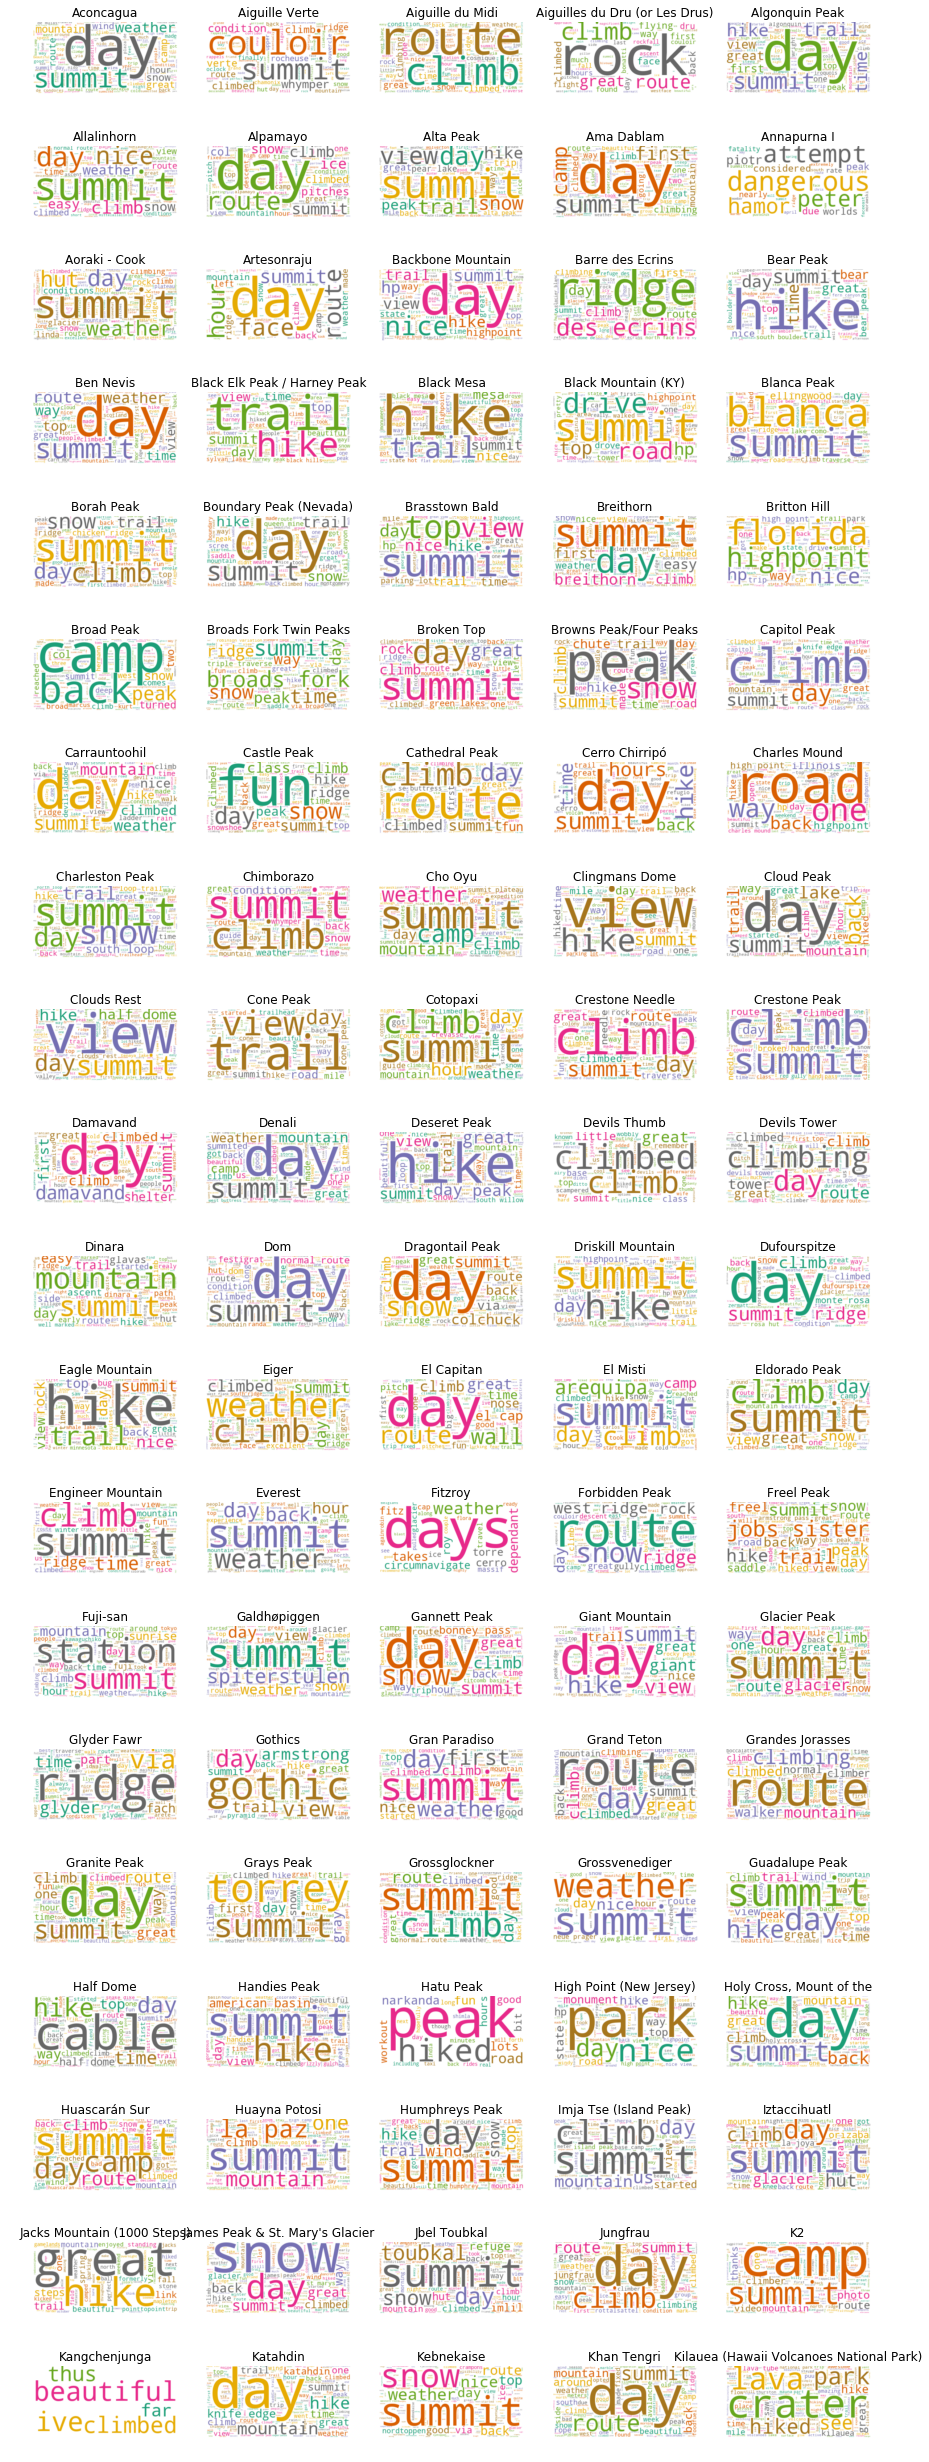

In [37]:
plt.rcParams['figure.figsize'] = [15,45]

for index, mountain in enumerate(data_dtm.columns):
    wc.generate(data_combined.comment[mountain])

    plt.subplot(20, 5, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(mountains[index])
    
plt.show()

## TF-IDF Vectorizer

In [ ]:
cv_tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = cv_tfidf.fit_transform(sample).toarray()
X_tfidf.shape

In [ ]:

feature_array = np.array(cv_tfidf.get_feature_names())
tfidf_sorting = np.argsort(X_tfidf.flatten()[::-1])

n = 10
top_n = feature_array[tfidf_sorting][:n]

## testing LSA topic modeling

In [ ]:
vectorizer = CountVectorizer(stop_words='english')
doc_word = vectorizer.fit_transform(sample)
doc_word.shape

In [ ]:
pd.DataFrame(doc_word.toarray(), index=sample, columns=vectorizer.get_feature_names()).head(10)

In [ ]:
lsa = TruncatedSVD(2) # getting N most important components/topics
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

In [ ]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2"],
             columns = vectorizer.get_feature_names())
topic_word

In [ ]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
display_topics(lsa, vectorizer.get_feature_names(), 5)

In [ ]:
Vt = pd.DataFrame(doc_topic.round(5),
             index = sample,
             columns = ["component_1","component_2" ])
Vt